# Build classificator

In order to build a classifier of landmarks, two popular neural network architectures were finetuned.
Networks whith "ResNet50" and "VGG19" backbones was trained on "Paris 6K" dataset. In this notebook I use only "OK" photos.

+ ## First, import required libraries and prepare the data. 

In [1]:
import tensorflow as tf
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, CSVLogger

import os
import numpy as np
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
PATH_TO_IMAGES="Paris_all/"

# Make dictionary with landmark classes
locations = {
    0:'Eiffel Tower',
    1:'Louvre',
    2:'Moulin Rouge',
    3:'Notre Dame',
    4:'Pompidou',
    5:'Arc de Triomphe',
    6:'Pantheon',
    7:"Musee d'Orsay",
    8:'Sacre Coeur',
    9:'Hotel des Invalides',
    10:'La Defense'
}

# "ok" photo's names
names=[]
handle=open("good_labels.txt", 'r')
for line in handle:
    names.append(line[:-1]+".jpg")
handle.close()

# shuffle dataset
names=np.random.permutation(names) 

In [6]:
%%time

# DataAdder helps divide datasets to "train" and "test"
def DataAdder(x_dataset,y_dataset, name):
    x_dataset.append(name)
    if (name.split('_')[1]=="eiffel"):
        y_dataset.append(0)
    elif (name.split('_')[1]=="louvre") :
        y_dataset.append(1)
    elif (name.split('_')[1]=="moulinrouge") :
        y_dataset.append(2)
    elif (name.split('_')[1]=="notredame") :
        y_dataset.append(3)
    elif (name.split('_')[1]=="pompidou") :
        y_dataset.append(4)
    elif (name.split('_')[1]=="triomphe") :
        y_dataset.append(5)
    elif (name.split('_')[1]=="pantheon") :
        y_dataset.append(6)
    elif (name.split('_')[1]=="museedorsay") :
        y_dataset.append(7)
    elif (name.split('_')[1]=="sacrecoeur") :
        y_dataset.append(8)
    elif (name.split('_')[1]=="invalides") :
        y_dataset.append(9)
    else :
        y_dataset.append(10)
        
# Store names to create tensor of resized images
x_train=[]
x_test=[]

# Store landmark's class
y_train=[]
y_test=[]
 
a=0
for name in names:
    if(a==24):
        a=0
    a+=1
    if (a<20) : 
        DataAdder(x_train, y_train, name)    
    else :
        DataAdder(x_test, y_test, name)

X_train= np.zeros((len(x_train),224,224,3))
X_test= np.zeros((len(x_test),224,224,3))

for i, name in enumerate(x_train):
    newImage = skimage.transform.resize(skimage.io.imread(PATH_TO_IMAGES+name), (224, 224), mode='constant')
    X_train[i] = newImage
for i, name in enumerate(x_test):
    newImage = skimage.transform.resize(skimage.io.imread(PATH_TO_IMAGES+name), (224, 224), mode='constant')
    X_test[i] = newImage

CPU times: user 1min 42s, sys: 792 ms, total: 1min 43s
Wall time: 1min 44s


Label: Sacre Coeur


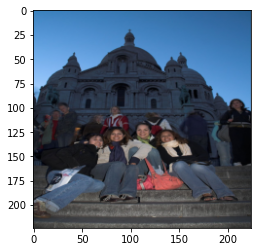

Label: Pompidou


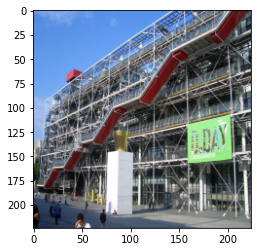

Label: Musee d'Orsay


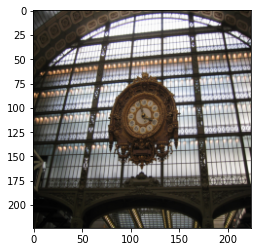

In [7]:
# Show some examples of images and labels
print("Label:", locations[y_train[0]])
plt.imshow(X_train[0])
plt.show()

print("Label:", locations[y_train[100]])
plt.imshow(X_train[100])
plt.show()

print("Label:", locations[y_train[300]])
plt.imshow(X_train[300])
plt.show()

In [8]:
# Convert labels to categorical OHE outputs
y_train_bin= to_categorical(y_train,num_classes=11,dtype='int8')
y_test_bin= to_categorical(y_test,num_classes=11,dtype='int8')

+ ## Finetune VGG19 backbone

In [2]:
# Using VGG19 pretrained model from tensornets, pre-trained on 1.2million labeled images from imagenet
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

In [9]:
# Freeze blocks 1-4 (layers 1-16)
# Train block 5 (layers 17-22) on our training data set
for layer in model.layers[:17]:
    layer.trainable = False

# Adding custom Layers to learn weights specific to this task 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(11, activation="softmax")(x) #predict our 11 landmark classessave_weights_only

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.01, momentum=0.4), 
                    metrics=["accuracy"])

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg19_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=4, verbose=1, mode='auto')
csv_logger = CSVLogger("vgg19_history_log.csv")


# Show final model layer summary with added layers
print("Final Model Architecture\nNumber of Layers:", len(model_final.layers))
model_final.summary()

Final Model Architecture
Number of Layers: 27
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (

In [10]:
%%time
# Training the model 
model_history = model_final.fit(
    X_train, y_train_bin,
    epochs = 15,
    validation_split = 0.2,
    batch_size = 4,
    callbacks = [checkpoint, early, csv_logger])

Epoch 1/15
241/241 [==============================] - 484s 2s/step - loss: 2.2934 - accuracy: 0.3124 - val_loss: 1.3487 - val_accuracy: 0.6141

Epoch 00001: val_accuracy improved from -inf to 0.61411, saving model to vgg19_1.h5
Epoch 2/15
241/241 [==============================] - 553s 2s/step - loss: 0.9343 - accuracy: 0.7440 - val_loss: 0.5483 - val_accuracy: 0.8299

Epoch 00002: val_accuracy improved from 0.61411 to 0.82988, saving model to vgg19_1.h5
Epoch 3/15
241/241 [==============================] - 503s 2s/step - loss: 0.8838 - accuracy: 0.7659 - val_loss: 1.8981 - val_accuracy: 0.7178

Epoch 00003: val_accuracy did not improve from 0.82988
Epoch 4/15
241/241 [==============================] - 515s 2s/step - loss: 0.4814 - accuracy: 0.8712 - val_loss: 0.6354 - val_accuracy: 0.7801

Epoch 00004: val_accuracy did not improve from 0.82988
Epoch 5/15
241/241 [==============================] - 490s 2s/step - loss: nan - accuracy: 0.7343 - val_loss: nan - val_accuracy: 0.0498

Epoch

+ ## Finetune ResNet50 backbone

In [23]:
# Using ResNet50 pretrained model, pre-trained on images from imagenet
model2=applications.ResNet50( include_top=False, input_shape = (224, 224, 3))

In [27]:
# Freeze blocks (1-4)
for layer in model2.layers[:-32]:
    layer.trainable = False

# Adding custom Layers to learn weights specific to this task 
x = model2.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions2 = Dense(11, activation="softmax")(x) #predict our 11 landmark classes

# creating the final model 
model2_final = Model(inputs = model2.input, outputs = predictions2)

# compile the model 
model2_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.01, momentum=0.4), 
                    metrics=["accuracy"])

# Save the model according to the conditions  
checkpoint2 = ModelCheckpoint("ResNet50_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early2 = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=1, mode='auto')
csv_logger2 = CSVLogger("ResNet50_history_log.csv")

#Show final model layer summary with added layers
print("Final Model Architecture\nNumber of Layers:", len(model2_final.layers))
model2_final.summary()

Final Model Architecture
Number of Layers: 180
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________

In [28]:
%%time
# Training the model 
model2_history = model2_final.fit(
    X_train, y_train_bin,
    epochs = 24,
    validation_split = 0.2,
    batch_size = 4,
    callbacks = [checkpoint2, early2,csv_logger2])

Epoch 1/24
241/241 [==============================] - 132s 538ms/step - loss: 2.4190 - accuracy: 0.1683 - val_loss: 3.2057 - val_accuracy: 0.1577

Epoch 00001: val_accuracy improved from -inf to 0.15768, saving model to ResNet50_1.h5
Epoch 2/24
241/241 [==============================] - 131s 544ms/step - loss: 1.9508 - accuracy: 0.3543 - val_loss: 1.6125 - val_accuracy: 0.4730

Epoch 00002: val_accuracy improved from 0.15768 to 0.47303, saving model to ResNet50_1.h5
Epoch 3/24
241/241 [==============================] - 130s 540ms/step - loss: 1.7774 - accuracy: 0.4204 - val_loss: 1.7021 - val_accuracy: 0.4357

Epoch 00003: val_accuracy did not improve from 0.47303
Epoch 4/24
241/241 [==============================] - 130s 541ms/step - loss: 1.6542 - accuracy: 0.4349 - val_loss: 1.8690 - val_accuracy: 0.3900

Epoch 00004: val_accuracy did not improve from 0.47303
Epoch 5/24
241/241 [==============================] - 132s 546ms/step - loss: 1.5558 - accuracy: 0.4689 - val_loss: 1.8079 - 

+ ## Сompare the obtained results

### VGG19 backbone

In [13]:
# Predict on the test data
model_final.load_weights("vgg19_1.h5") # load best wights

predictions = model_final.predict(X_test)
cm = confusion_matrix(y_test, predictions.argmax(axis=1))

print("Correct Classifications:", np.trace(cm))
print("Total Classifications Made:", len(y_test))
print("Test Accuracy:", '{:0.4f}'.format(np.trace(cm)/ len(y_test)))

Correct Classifications: 268
Total Classifications Made: 315
Test Accuracy: 0.8508


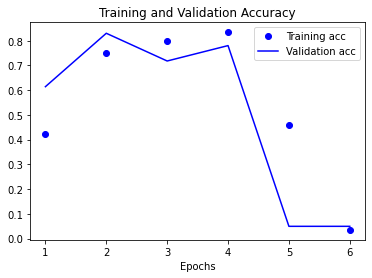

In [43]:
%matplotlib inline

# plot the accuracy rates for each epoch on training and validation data
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs1 = range(1, len(acc) + 1)
plt.plot(epochs1, acc, 'bo', label='Training acc')
plt.plot(epochs1, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.legend()
plt.show()

### ResNet50 backbone

In [29]:
# Predict on the test data
model2_final.load_weights("ResNet50_1.h5") # load best wights

predictions2_full = model2_final.predict(X_test)
cm2 = confusion_matrix(y_test, predictions2_full.argmax(axis=1))

print("Correct Classifications:", np.trace(cm2))
print("Total Classifications Made:", len(y_test))
print("Test Accuracy:", '{:0.4f}'.format(np.trace(cm2)/ len(y_test)))

Correct Classifications: 205
Total Classifications Made: 315
Test Accuracy: 0.6508


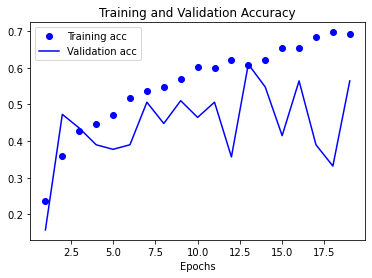

In [41]:
%matplotlib inline
# plot the accuracy rates for each epoch on training and validation data

acc2 = model2_history.history['accuracy']
val_acc2 = model2_history.history['val_accuracy']
epochs2 = range(1, len(acc2) + 1)
plt.plot(epochs2, acc2, 'bo', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.legend()
plt.show()

+ ## Evaluate the first model

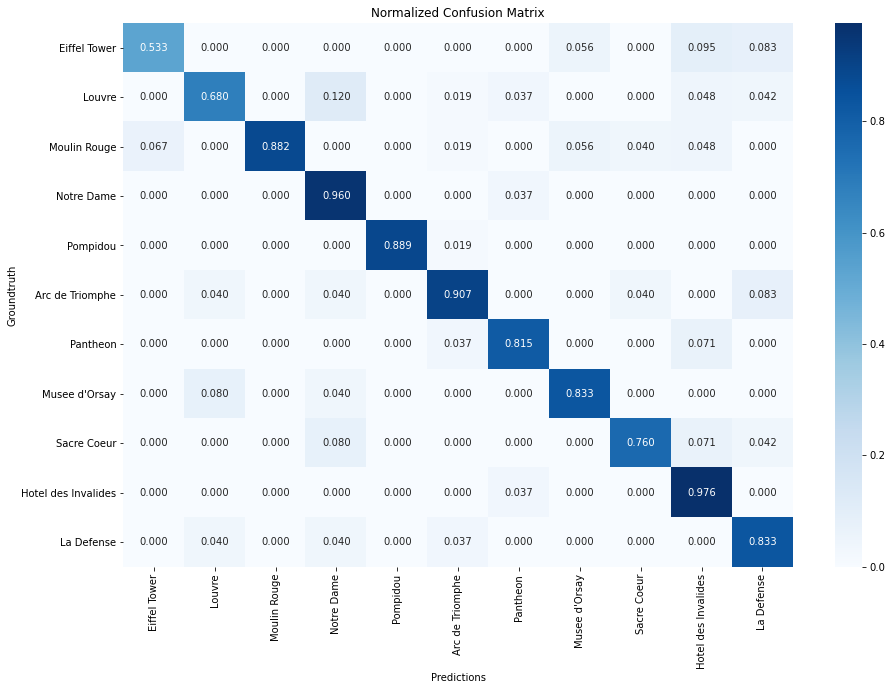

In [78]:
# Normalized confusion matrix
np.set_printoptions
cm_normalized = cm / cm.astype(np.float).sum(axis=1)
cm_normalized.round(decimals=3)

ticks = locations.values()
plt.figure(figsize = (15,10))
sns.heatmap(cm_normalized, annot=True, cmap = "Blues", fmt='0.3f', xticklabels=ticks, yticklabels=ticks)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Groundtruth")
plt.show()

In [80]:
# Define functions to calculate precision and recall values
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

print("Label Location                         Precision Recall")
print("--------------------------------------------------------")
precision_scores = []
recall_scores = []
for label in range(11):
    precision_scores.append(precision(label,cm))
    recall_scores.append(recall(label,cm))
    print(f"{label:5d} {locations[label]:30s} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

Label Location                         Precision Recall
--------------------------------------------------------
    0 Eiffel Tower                       0.889  0.533
    1 Louvre                             0.810  0.680
    2 Moulin Rouge                       1.000  0.882
    3 Notre Dame                         0.750  0.960
    4 Pompidou                           1.000  0.889
    5 Arc de Triomphe                    0.875  0.907
    6 Pantheon                           0.880  0.815
    7 Musee d'Orsay                      0.882  0.833
    8 Sacre Coeur                        0.905  0.760
    9 Hotel des Invalides                0.745  0.976
   10 La Defense                         0.769  0.833


## Conclusion

In order to improve the result, it is necessary to increase the amount of training data, it is possible to change the structure of the last layers of the neural network. 

To solve recognition problems, there are more complex and effective approaches associated with extracting descriptors from images. The use of such algorithms (for example, "Delf") can lead to accuracy increasing.

